In [32]:
#Louis EDA


In [1]:
#EDA
#booking_price_covers
#drop

#how many people does the price per night cover (can be lower than the max. guests in which case an additional fee is asked per extra person, which is not provided here)
#dus eigenlijk: als je het verschil berekent tussen (max_guests - booking_price_covers), hoe groter dit is, hoe lager de target is. Een appa voor 4 personen aan 90 euro geadverteerd, terwijl er 8 personen kunnen slapen en het totaal dan 170 euro zou zijn.


In [2]:
#EDA
#booking_min_nights
#MAYBE include

#is relevant in other models, but not really here


In [56]:
#EDA
#booking_availability_30
#booking_availability_60
#booking_availability_90
#booking_availability_365


#include booking_availability_60
#drop all others

corr_matrix = df[['booking_availability_30', 'booking_availability_60', 'booking_availability_90', 'booking_availability_365', 'target']].corr()
corr_matrix = corr_matrix.rename(columns={'booking_availability_30': '30',
                                          'booking_availability_60': '60',
                                          'booking_availability_90': '90',
                                          'booking_availability_365': '365'})
corr_matrix = corr_matrix.rename(index={'booking_availability_30': '30',
                                         'booking_availability_60': '60',
                                         'booking_availability_90': '90',
                                         'booking_availability_365': '365',
                                         'target': 'target'})
print(corr_matrix)

              30        60        90       365    target
30      1.000000  0.937023  0.867056  0.550713 -0.018858
60      0.937023  1.000000  0.964066  0.617441 -0.011502
90      0.867056  0.964066  1.000000  0.662169 -0.005670
365     0.550713  0.617441  0.662169  1.000000 -0.015625
target -0.018858 -0.011502 -0.005670 -0.015625  1.000000


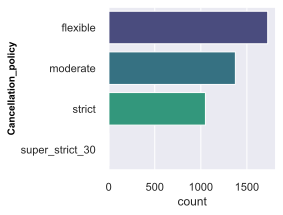

In [58]:
#EDA
#booking_cancel_policy
#include (make 3 dummy's)

sns.set(style='darkgrid')
plt.figure(figsize=(3,3))
sns.countplot(y = df['booking_cancel_policy'],order = df['booking_cancel_policy'].value_counts().index,palette = "viridis")
plt.ylabel('Cancellation_policy',fontsize = 10, weight = 'bold',color='black')
#plt.axes().set(facecolor = "White")
plt.show()


Text(0.5, 1.0, '\nMedian Prices by Cancellation Policy\n')

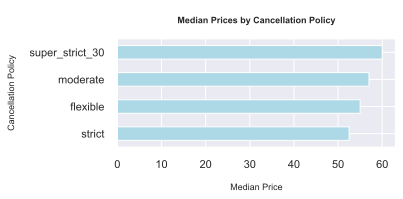

In [60]:
import numpy as np
df_grouped = pd.DataFrame(df.groupby(['booking_cancel_policy'])['target'].agg(np.median))
df_grouped.reset_index(inplace=True)

df_grouped.sort_values(by=['target'], ascending=True)\
          .plot(kind='barh', x='booking_cancel_policy', y='target', 
                figsize=(5,2), legend=False, color='lightBlue')

plt.xlabel('\nMedian Price', fontsize=9)
plt.ylabel('Cancellation Policy\n', fontsize=9)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=9, fontweight='bold')
#deze bron: https://www.kaggle.com/code/lowlypalace/airbnb-price-prediction-using-machine-learning

#df.booking_cancel_policy.unique()
#df = pd.concat([df, pd.get_dummies(df['booking_cancel_policy'], prefix='booking_cancel_policy')],axis=1)
#df = df.drop(['booking_cancel_policy'],axis=1)

In [39]:
#EDA
#include reviews_rating make a 'perfect' dummy for scores from 94-100 (those are significantly more expensive than others)
#include reviews_per_month (as a number)
#drop all others

#reviews_num
#reviews_rating
#reviews_acc
#reviews_cleanliness
#reviews_checkin
#reviews_communication
#reviews_location
#reviews_value
#reviews_per_month

#reviews_rating geef 69 voor perfect94-100 en voor anderen 66 (er zijn wel 1400 Nas)
#cleanliness geeft 69 voor perfect10 en voor anderen 66 (er zijn wel 1400 Nas) -----> idem location, value, acc, communication
#checkin geen effect

#aangezien ze niet echt multicorrelated zijn EN we ze kunnen bucketen
#er zijn wel altijd 1400 NAs dus mss aparte category maken? deleten? eerder nieuwe obs zonder reviews so far? zie https://nbviewer.org/github/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb#Categorical-features


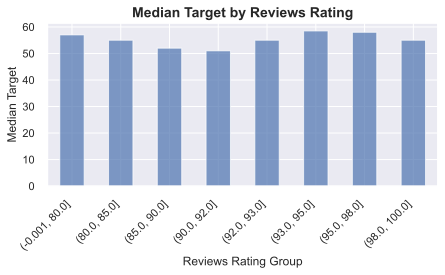

In [42]:
#reviews_rating

#dummy maken van 97-100 en other? results zijn heel verschillend na standaardiseren/meanVSmedian/qWijzigen

# Split reviews_rating into 7 groups
df['reviews_rating_group'] = pd.qcut(df['reviews_rating'], q=10, duplicates='drop')

# Calculate median target for each group
median_target = df.groupby('reviews_rating_group')['target'].median()

# Plot median target for each group
plt.figure(figsize=(7,3))
median_target.plot(kind='bar', color='b', alpha=0.7)
plt.title('Median Target by Reviews Rating', fontsize=14, fontweight='bold')
plt.xlabel('Reviews Rating Group', fontsize=12)
plt.ylabel('Median Target', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


In [43]:
#df['reviews_per_month'] = pd.qcut(data['reviews_per_month'], q=3, labels=["reviews_per_month_low", "reviews_per_month_medium","reviews_per_month_high"])

In [47]:
#EDA
#extra (superhost, profile pic etc.)
#include df['extra: Instant Bookable']
#include interactie: df['int_ProfilePic_Location_InstantBookable'] = df['extra: Host Has Profile Pic'] * df['extra: Is Location Exact'] * df['extra: Instant Bookable']
#drop others

    #extra: Instant Bookable
    #extra: Host Is Superhost
    #extra: Host Identity Verified
    #extra: Is Location Exact
    #extra: Host Has Profile Pic

In [48]:
    #De belangrijkste dummy's in ons model opnemen, de rest niet (zonder overfitting)
    #Door voor alle dummy's én bij interactie te kijken of (1) de mean verschillend is en (2) er voldoende observaties in de subgroep zitten
        #Results:
        #zijn relevant, tenzij we het model op kleine subgroepen willen trainen ook:
            #df['extra: Instant Bookable'] ->> mean is 70.6 ipv 67 (5000 en 1500 observaties)
            #interactie: Host Has Profile Pic, Is Location Exact, Instant Bookable ->> mean is 73 (600 observaties) 
           

In [50]:
df['extra'] = df['extra'].fillna('')
extras_list = df['extra'].tolist()
extras_set = set()
for extra_string in extras_list:
    if pd.notnull(extra_string):
        extras = extra_string.split(',')
        for extra in extras:
            stripped_extra = extra.strip()
            if stripped_extra and stripped_extra not in ['Require Guest Phone Verification', 'Require Guest Profile Picture']:
                extras_set.add(stripped_extra)

def new_dum_col_filling(main_col_val, dum_col_name, main_col_name):
    if dum_col_name.replace(main_col_name + ': ', '') in main_col_val:
        return 1
    else:
        return 0
    
def new_set_to_dummies(df, column_name):
    new_all_values_of_sets = extras_set
    new_dummy_columns_name = [column_name + ': ' + dum_col for dum_col in new_all_values_of_sets if dum_col]
    new_dummy_df = pd.DataFrame(0, index=df.index, columns=new_dummy_columns_name)
    for dum_col_name in new_dummy_columns_name:
        for i in df.index:
            new_dummy_df[dum_col_name][i] = new_dum_col_filling(df[column_name][i], dum_col_name, column_name)
    df = pd.concat([df, new_dummy_df], axis=1)
    return df
    
df = new_set_to_dummies(df, 'extra')
    
df = df.drop(['extra'],axis=1)


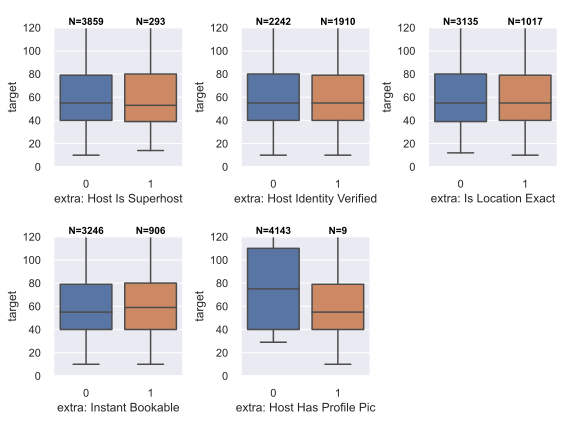

In [51]:
# Define a function to add count labels to boxplot
def add_count_labels(plot, df, column):
    # Get counts per category
    counts = df[column].value_counts()
    # Get y limit of plot
    y_limit = plot.get_ylim()[1]
    # Add count labels to plot
    for i, v in enumerate(counts.values):
        plot.text(i, y_limit*1.02, f'\nN={v}', horizontalalignment='center', size='small', color='black', weight='semibold')

# Create subplots
f, ax = plt.subplots(figsize=(8, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4) # adjust space between subplots

# Create boxplots and add count labels
ax1 = plt.subplot(2, 3, 1)
sns.boxplot(data=df, y='target', x='extra: Host Is Superhost')
plt.ylim(0, 120)
add_count_labels(ax1, df, 'extra: Host Is Superhost')

ax2 = plt.subplot(2, 3, 2)
sns.boxplot(data=df, y='target', x='extra: Host Identity Verified')
plt.ylim(0, 120)
add_count_labels(ax2, df, 'extra: Host Identity Verified')

ax3 = plt.subplot(2, 3, 3)
sns.boxplot(data=df, y='target', x='extra: Is Location Exact')
plt.ylim(0, 120)
add_count_labels(ax3, df, 'extra: Is Location Exact')

ax4 = plt.subplot(2, 3, 4)
sns.boxplot(data=df, y='target', x='extra: Instant Bookable')
plt.ylim(0, 120)
add_count_labels(ax4, df, 'extra: Instant Bookable')

ax5 = plt.subplot(2, 3, 5)
sns.boxplot(data=df, y='target', x='extra: Host Has Profile Pic')
plt.ylim(0, 120)
add_count_labels(ax5, df, 'extra: Host Has Profile Pic')

plt.tight_layout() # avoid overlap of plots
plt.draw()


In [3]:
#EDA
#target
#trim: only use 25% - 75% 
    #but find a scientifically proven way to justify this (z score trimming per feature)